In [1]:
# Note: Add feedback delay on Aug.312018
# Note: add single particel beam dynamics, starting at Aug. 302018, done in
#Note: Add beam dynamic loop in the code  at Oct.12, 2018
#Add current ramping at oct252018
# This is to check Robinson stability
#Checked with Mike and Tianmu on 11/6/2018
#Check the delta frequency sign on 11/7/2018
#Checked the bunch center issue on 11/15/2018
#correct klystron phase, beam phase, check all the voltage on 12/12/2018

In [2]:
#physical constant
clight=299792458      # m/s
me0=9.107e-31 # mass of electron kg
eps0=8.854e-12   # permitivity of free-space
mu0=4*pi*1e-7  # H/m

qe=1.602e-19 #C
Bzk=1.380e-23 # Boltzmann's constant j/K
Pkh=6.626e-34  # Planck's constant  J-sec
re0=qe^2/(me0*clight^2)  # classical radius of electron
Cgamma=4*pi/3*re0/(me0*clight^2)^3*(qe*10^9)^3  # m/GeV^3  This is sychrotron radiation constant

using PyPlot
using Distributions
using Dates
using ControlSystems
using FFTW
using JLD
using LsqFit
using DelimitedFiles

donetime=Dates.format(now(), "dd-HH:MM:SS")
starttime=DateTime(now())
Dates.value(starttime)
usec=1e-6;MHz=1e6;kW=1000;MW=1e6;mA=0.001;MV=1e6;deg=1;rad=1;Hz=1;kHz=1000;

Cgamma 

9.847686134697719e-15

In [3]:
# Ring parameters
Crev=3834.9; frev=clight/Crev; f9MHz=frev*120; f28MHz=frev*360; T28MHz=1/f28MHz; f56MHz=frev*720
harm1=720*10; frf=f56MHz*10*Hz;dT=Crev/clight/360*1e6 # in usec

gammat=31. ; gamma0=9.785e3 ; vrf=22.0e6;phisynch=170.5*pi/180; omegarf=2*pi*frf;Trf=1/frf;
trev=Crev/clight;omega_rev=2*pi/trev;
ebeta= sqrt(1-1/gamma0^2)
eta = 1/gammat^2 - 1/gamma0^2;
r0=qe^2/me0/clight^2;
pcoeff = -1*vrf*omegarf/(0.511e6)  # this "0.511 MeV" has to change to 9.38e6 for proton
synchronous_volt= vrf*sin(phisynch)
tcoeff = trev*eta/(ebeta^2*gamma0)
rcoeff = pcoeff/tcoeff
synchrotron_tune = sqrt(-pcoeff*tcoeff)/(2*pi)
tunesexact = acos(1+pcoeff*tcoeff/2)/(2*pi)
fsyn = synchrotron_tune/trev
print("#############")
print("synchrotron_tune=",synchrotron_tune,",  fsyn=",fsyn,", frf=",frf/1e6,", eta=",eta)
# Getinput

iseed=171487 ;
aatom=1 ; qatom=1.  ; taupart=0.65e-11 ; tauhat=1.87e-10  ;
harmbtf=0.1 ; phibtf=1.
tradperp=5.e-2  ; sigperp=3.6e-4   #nominal rms transverse size
tradlong=2.5e-2 ; siglong=5.4

print("fsyn=",fsyn)
eta

#############synchrotron_tune=0.0724324071397075,  fsyn=5662.387383052925, frf=562.8584050692326, eta=0.0010405722820507415fsyn=5662.387383052925

0.0010405722820507415

In [4]:
50*31.e10

1.55e13

##0  Ne*qe/trev=Ib0=0.1352548747381366
#1 Vg1=2.2679078541542802e7,Vb=810584.5301786391,kly_angle=0.5677887151556975,cos(kly_angle)=0.8430921960059392
##2  tanPsi=-1.0661011022698101, cos(atan(tanPsi))=0.6841341636902152, Pbeam=0.491116851643337MW
##3  sp_ampl*cos(sp_phase*pi/180)=3.631047328934912e6,sp_ampl*sin(phisynch)=,3.631047328934918e6
##4  synchronous_volt=3.631047328934918e6, kly_FF_ampl=3.1362029272590533e7
##5 Max(Ib)=0.1352548747381366kly_Pfwd/1e6=,31.362029272590533, detuningfre=60000.0
##6 tanPsi=-1.0661011022698101, atan(tanPsi)=-46.83244797948569, cos(atan(tanPsi))=0.6841341636902152, Pbeam=0.491116851643337MW
##7 Pg=31.362029272590533MW, optterm=1.2526501204232958, dEperturn=3.631047328934912MV
##8 Popt=13.812785388127853MW, optdetune=-2989.4404243516447,detuningfreq=60000.0 sp_phase=80.49999999999999
##9 check the voltate: volt_beam=3.631047328934912e6, volt_syn=,3.631047328934918e6,kly_FF_ampl=3.1362029272590533e7

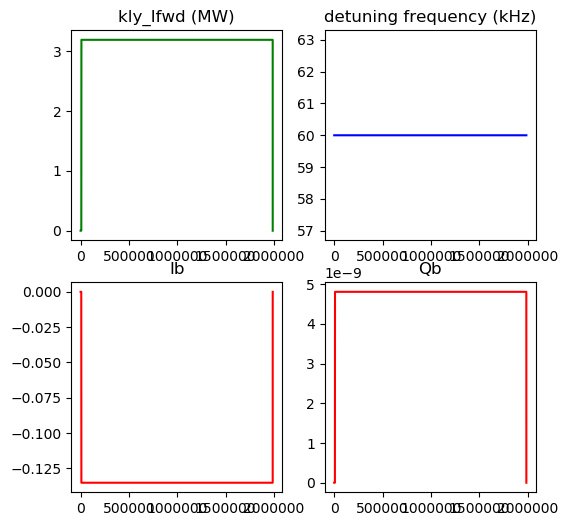


##10 Ib0=0.1352548747381366,kly_Pfwd=31.362029272590533, detuningfre=60000.0
##11 Vg=22.6790785415428MV


PyObject Text(0.5, 1.0, 'Qb')

In [41]:
# Get filling#########################################################################
Nturn=5500  # beam turns
DT=dT*usec; # in usec
Nwait=100;Nfill=7000;Nbucket=360;Nflat=Nbucket*Nturn;Nfall=Nbucket;
Nstart=Nwait+Nfill; Nend=Nwait+Nfill+Nflat+Nfall;Tend=Nend*DT;  # Total time is defined
time_wait=Nwait*DT;time_fill=Nfill*DT;time_flat=Nflat*DT;time_fall=Nfall*DT;
time_total=(1:Nwait+Nfill+Nflat+Nfall)*DT;
NstartFB=0; # start time (index) of the feedback system

initialcurrentfactor=1
#Cavity
Q0=2.3e10;RoQ=146*12;Z0=50;Lcav=0.5352;Qload=0*2.7e4+5e3;deltaf=60000;
fres=frf-deltaf #predetune in Hz
deltaW=0;rho=RoQ/2; # (rho is the half of Rshunt/Qo, i.e circuit definition)
Rsh=Q0*RoQ;R=Rsh/2;wo=2*pi*fres;Tfill=2*Qload/wo;w12=wo/(2Qload);Rload=rho*Qload; #( Rload is circuit definition)
n_coupler=sqrt(RoQ*Qload/2/Z0)  #n_coupler=sqrt(R/Z0*Qload/(Q0-Qload));
beta=Q0/Qload-1;tanPsi0=-2*Qload*deltaf/(fres);Zcav=Rload/(1-1im*tanPsi0);dUdt=zeros(Nend);

#Beam
Nturn_delay=0;Nturn_beamfill=Nturn-2*Nturn_delay #( this is to setup the beam has the same delay and early turnoff)
Nturn_beamoff_early=(Nturn-Nturn_beamfill-Nturn_delay)*Nbucket;
Nbunch=360;Ngap=Nbucket-Nbunch;Nbeam_delay=(Nturn_delay)*Nbucket;Nbeam_coeff=1;
fbunch=f28MHz;
Nbeamon=Nwait+Nfill+Nbeam_delay;Nbeamoff=Nbeamon+Nturn_beamfill*Nbucket;Ib_phase=pi;Ib=0;Pb=0;
beamXturn=vcat(ones(Nbunch),zeros(Ngap));
currentfactor=1; m=1;modx=1;modtimes=0

for i=1:Nturn_beamfill-1
    if mod(i,modx)==0
        currentfactor=1+m*modtimes
        m=m+1
    end
    append!(beamXturn,currentfactor*vcat(ones(Nbunch),zeros(Ngap)))
    i=i+1
end

#Bunch
Ne=1*initialcurrentfactor;Volt_error=zeros(Complex{Float64},Nend);

Qb0=3.0*1e10*qe*Ne;
Qb=Qb0*vcat(zeros(Complex{Float64},Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Nend-Nflat-Nwait-Nfill+Nturn_beamoff_early));

Ib0=Qb0*Nbunch/trev; #( minus sign here is the direction of the Ib in the phasor plot)
Ib_ampl=Ib0*vcat(zeros(Complex{Float64},Nwait+Nfill+Nbeam_delay),beamXturn,zeros(Nend-Nflat-Nwait-Nfill+Nturn_beamoff_early));
Ib=Ib_ampl*exp(1im*Ib_phase);Pbeam=zeros(Complex{Float64},Nend);

println("##0  Ne*qe/trev=Ib0=",Ib0)


# ceated mechanical model
mech_fm=[280 340 420];mech_Qm=[100 100 100];mech_Km=[0.4 0.3 0.2]*1e-12;mech_DW=zeros(3,Nend);
mech_dDWdt=zeros(3,Nend);mech_time=0;mech_wave=0;mech_uphonics=0 ;#+/- Hz detuning due to microphonics
mech_wm=2*pi*mech_fm;

# create simulation parameters
Vc_sim=zeros(Complex{Float64},Nend);detune_sim=zeros(Complex{Float64},Nend);err_sim=zeros(Complex{Float64},Nend);
Itotal_sim=zeros(Complex{Float64},Nend);
Icav_sim=zeros(Complex{Float64},Nend);Iref_sim=zeros(Complex{Float64},Nend);Isp_sim=zeros(Complex{Float64},Nend);
Nloopdelay_sim=floor(0*usec/DT);
#Kp_sim=0;Ki_sim=0;sysgain=10; DT_sim=DT;
Kp_sim=1*105;Ki_sim=10;sysgain=3; DT_sim=DT;


# setpoint

sp_ampl=synchronous_volt/sin(phisynch);sp_phase=(pi/2-(pi-phisynch))*180/pi*deg;sp_wait=zeros(Nwait);tau=Qload/wo;
sp_fill=sp_ampl*exp(1im*pi/180*sp_phase*0)*(1.0.-exp.(-time_total[1:Nfill]/tau));
sp_flat=sp_ampl*exp(1im*pi/180*sp_phase*0)*ones(Nflat);
sp_fall=zeros(Complex{Float64},Nfall);
sp_volt=vcat(sp_wait,sp_fill,sp_flat,sp_fall);  # voltage set point
Popt=sp_volt.^2/(4*RoQ*Qload); # this is only when the coupling is right.
function Pg_power(currentfactor)
  a1=sp_ampl^2/4/RoQ/Q0*(beta+1)^2/beta;
  a2=(1+RoQ*Q0*abs(Ib0*currentfactor)*cos(pi/180*sp_phase)/sp_ampl/(1+beta))^2;
  a3=(deltaf*currentfactor/(w12/2/pi)+RoQ*Q0*(Ib0*currentfactor)*sin(pi/180*sp_phase)/sp_ampl/(1+beta))^2;
  Pg=a1*(a2+a3)/1e6;
  return Pg,a3
end
Pg,a3=Pg_power(1)


Vg=sqrt(Pg*1e6*RoQ*Qload)*2*cos(atan(tanPsi0))#(voltage generated by klystron only)

dfopt=-RoQ*Qload*Ib0*sin(pi/180*sp_phase)/sp_ampl*(w12/2.0/pi);
dEperturn=sp_ampl*cos(pi/180*sp_phase)

#Get klystron angle
Vg1=sqrt(Pg*1e6*RoQ*Qload)*2*cos(atan(tanPsi0))#(voltage generated by klystron only)
#Vg2=abs(kly_Ifwd[Nbeamon+4*Nbucket])*RoQ*Qload*cos(atan(tanPsi0))
Vb1=Ib0*RoQ*Qload*cos(atan(tanPsi0))
if (Vg1^2+Vb1^2-sp_ampl^2)/(2*abs(Vg1)*Vb1)<1
    kly_angle=acos((Vg1^2+Vb1^2-sp_ampl^2)/(2*Vg1*Vb1))
else
    kly_angle=0
end
#kly_angle1=acos(synchronous_volt/sqrt(Vg1^2+Vb1^2))
println("#1 Vg1=",Vg1,",Vb=",Vb1,",kly_angle=",kly_angle,",cos(kly_angle)=",(Vg1^2+Vb1^2-sp_ampl^2)/(2*abs(Vg1)*Vb1))
#plot(kly_Ifwd)


#Klystron
kly_fillcoeff=1;kly_flatcoeff=1;kly_flat_phase=0;kly_phase=0;klyGain_dB=0.00;kly_gain=10^(klyGain_dB/20);

RFpulseXturn=vcat(ones(Nbunch),ones(Ngap)); detuneXturn=deltaf*vcat(ones(Nbunch),ones(Ngap))
currentfactor=1;m=1; kly_FF_ampl=0
for i=1:Nturn-1
    if mod(i,modx)==0
        currentfactor=1+m*modtimes
        m=m+1
    end
    kly_FF_ampl=Pg_power(currentfactor)[1]*MW;
    append!(RFpulseXturn,kly_FF_ampl*vcat(ones(Nbunch),ones(Ngap)))
    detune=deltaf*currentfactor
    append!(detuneXturn,detune*vcat(ones(Nbunch),ones(Ngap)))
    i=i+1
end

detuningfreq=vcat(deltaf*ones(Complex{Float64},Nwait),deltaf*ones(Nfill),detuneXturn,deltaf*ones(Nfall));

kly_FF_phase=real(kly_angle);kly_Pmax=0*Pg*MW;
RFpulse=vcat(zeros(Complex{Float64},Nwait),kly_fillcoeff^2*ones(Nfill),RFpulseXturn,zeros(Nfall));
kly_Pfwd=RFpulse;
Ifwd_prime_ampl=sqrt.(2*kly_Pfwd/Z0);
Ifwd_prime_phase=vcat(zeros(Complex{Float64},Nwait),kly_FF_phase*ones(Nfill),(kly_FF_phase+kly_flat_phase)*ones(Nflat),zeros(Nfall));
Ifwd_prime=Ifwd_prime_ampl.*exp.(1im*Ifwd_prime_phase); # forwad current on klystron side
kly_Ifwd=Ifwd_prime/n_coupler   # forward current on cavity side
kly_Pref=zeros(Complex{Float64},Nend);
#26



#save("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq",detuningfreq,"Ib",Ib,"kly_Pfwd",kly_Pfwd,"Qb",Qb)

#d=load("/Users/wxu/Desktop/juliaDataSave/setup.jld","detuningfreq")

println("##2  tanPsi=",tanPsi0,", cos(atan(tanPsi))=",cos(atan(tanPsi0)),", Pbeam=",sp_ampl/1e6*Ib0*cos(pi/180*sp_phase),"MW")


println("##3  sp_ampl*cos(sp_phase*pi/180)=",sp_ampl*cos(sp_phase*pi/180),",sp_ampl*sin(phisynch)=,",sp_ampl*sin(phisynch))
println("##4  synchronous_volt=",synchronous_volt,", kly_FF_ampl=",kly_FF_ampl)  # check the voltate is correct.

#plx_start=Nbeamon-Nbeam_delay;plx_stop=Nbeamoff
#plot(abs.(sp_volt)[plx_start:plx_stop]/1e6,"b-",label="Vc_sp")
#ylim(sp_ampl/1e6*(1-0.15),sp_ampl/1e6*(1+0.05))
#legend()
#subplot(221)
#plot(kly_Pfwd/1e6,"g",abs.(detuningfreq)/5e3,"b")
#subplot(222)
#plot(-Ib*10,"r",Qb*1e5,"y")
println("##5 Max(Ib)=",maximum(abs.(Ib)),"kly_Pfwd/1e6=,",maximum(abs.(kly_Pfwd/1e6)),", detuningfre=",maximum(abs.(detuningfreq)))

#print
println("##6 tanPsi=",tanPsi0,", atan(tanPsi)=",atan(tanPsi0)*180/pi,", cos(atan(tanPsi))=",cos(atan(tanPsi0)),", Pbeam=",sp_ampl/1e6*Ib0*cos(pi/180*sp_phase),"MW")
println("##7 Pg=",Pg,"MW, ","optterm=",a3,", dEperturn=",dEperturn/1e6,"MV")

println("##8 Popt=",maximum(abs.(Popt))/1e6,"MW, optdetune=",dfopt,",detuningfreq=",maximum(real.(detuningfreq))," sp_phase=",sp_phase)
println("##9 check the voltate: volt_beam=",sp_ampl*cos(sp_phase*pi/180),", volt_syn=,",sp_ampl*sin(phisynch),",kly_FF_ampl=",kly_FF_ampl)  # check the voltate is correct.
println("##10 Ib0=",maximum(abs.(Ib)),",kly_Pfwd=",maximum(abs.(kly_Pfwd/1e6)),", detuningfre=",maximum(abs.(detuningfreq)))
println("##11 Vg=", Vg/1e6,"MV")


fig = figure(figsize=(6,6))
subplot(221)
#plot(kly_Pfwd/1e6,"g")
plot(kly_Ifwd,"g")
title("kly_Ifwd (MW)")
subplot(222)
plot(abs.(detuningfreq)/1e3,"b")
title("detuning frequency (kHz)")
subplot(223)
plot(Ib,"r")
title("Ib")
subplot(224)
plot(Qb,"r")
title("Qb")


#########################################################################



In [42]:
0.13/0.09*2


2.8888888888888893

In [43]:
#Get klystron angle
Vg1=sqrt(Pg*1e6*RoQ*Qload)*2*cos(atan(tanPsi0))#(voltage generated by klystron only)
Vg2=abs(kly_Ifwd[Nbeamon+1*Nbucket])*RoQ*Qload*cos(atan(tanPsi0))
Vb1=0.1*RoQ*Qload*cos(atan(tanPsi0))#  Ib0*RoQ*Qload*cos(atan(tanPsi0))
#kly_angle=real(acos((Vg1^2+Vb1^2-sp_ampl^2)/(2*abs(Vg1)*Vb1))*180/pi)
#kly_angle1=acos(synchronous_volt/sqrt(Vg1^2+Vb1^2))*180/pi
println("Vg1=",Vg1," Vg2=",Vg2," Vb1=",Vb1,", cos=",(Vg1^2+Vb1^2-sp_ampl^2)/(2*abs(Vg1)*Vb1))

Vg1=2.2679078541542802e7 Vg2=4049.7044299110253 Vb1=599301.5273926286, cos=1.1293648774311826


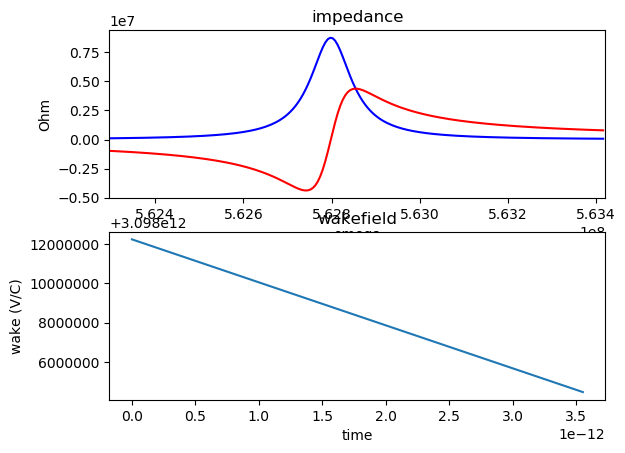

single partilce=6967.919999215631 + 7428.5071916916395imWakemodel=6967.919999215631 + 7428.5071916916395im

In [44]:
# Single mode Impedance and wake
function Zcavity(f,df)
    Qext=1/(1/Qload-1/Q0)
    fcavity=frf-df
    Z=Qload*RoQ/(1+(Qload*(fcavity/f-f/fcavity))*1im)
    return Z
end

subplot(211)
wf=frf/1.001:frf/1e5:1.001*frf
plot(wf,map(x->real(Zcavity(x,deltaf)),wf),"b-")
plot(wf,map(x->imag(Zcavity(x,deltaf)),wf),"r-")
xlim(frf/1.001,1.001frf)
title("impedance")
xlabel("omega")
ylabel("Ohm")

function wakemode(omega0,RoQ,Ql,t)
    Qext=1/(1/Ql-1/Q0)
    tau0=2*Qext/omega0
    Q1=sqrt(1-1/Qext^2)
    Q2=1/sqrt(4*Qext^2-1)
    aa=cos(omega0*Ql*t)
    bb=Q2*sin(omega0*Q1*t)
    return 0.5*omega0*RoQ*exp(-t/tau0)*(aa-bb)
end
subplot(212)
t=0:2pi/omegarf/1000:2pi/omegarf*0.002
wt=map(x->wakemode(omegarf,RoQ,Qload,x),t)
plot(t,wt)
title("wakefield")
xlabel("time")
ylabel("wake (V/C)")
Vb01=0.5*RoQ*fres*2pi*Qb[Nbeamon+1]*cos(detuneAngle[Nbeamon+1])*exp(1im*detuneAngle[Nbeamon+1])  # bunch induced total voltage   
Vb02=Qb[Nbeamon+1]*wakemode(fres*2pi,RoQ,Qload,0)*cos(detuneAngle[Nbeamon+1])*exp(1im*detuneAngle[Nbeamon+1])  #wak
print("single partilce=",Vb01,"Wakemodel=",Vb02)

In [45]:
#########################################################################
Qbfactor=1.0
#Directive
dir_FB=0;dir_BeamOn=1;dir_track=0;dir_LFD=0;dir_pzt=0;wakeON=1;Rad_on=0
#Kp_sim=1*0;Ki_sim=0;sysgain=0; 
Kp_sim=-1*105;Ki_sim=-10;sysgain=-3;

# simulation
FB_i=0  # initial value for the integral feedback gain term
deltaW=2pi*(real(detuningfreq).+(2*rand(1)[1]-1)*mech_uphonics)
tanPsi=2*Qload*deltaW./(frf.-real(detuningfreq))/2/pi
detuneAngle=atan.(real.(tanPsi))
# Initial delta_gamma and delta_t of the bunch
delta_gamma_all=zeros(Complex{Float64},Nend)
delta_t2_all=zeros(Complex{Float64},Nend)
delta_syn_phase=zeros(Complex{Float64},Nend)
bunch_Vb=zeros(Complex{Float64},Nend)
bunch_Vb2=zeros(Complex{Float64},Nend)
delta_gamma2_ini=rand(Normal(0, gamma0*1e-9), iseed)[1:Nbunch];
delta_t2_ini=rand(Normal(0, taupart*1e-3), iseed)[1:Nbunch];
BD_delay=0
Nbeamon2=Nbeamon+Nbucket*BD_delay
for i=1:Nbunch
    delta_gamma_all[Nbeamon2+i]=delta_gamma2_ini[i]-gamma0*0*1e-3
    delta_t2_all[Nbeamon2+i]=delta_t2_ini[i]-taupart*0
end

 # beam generated voltage
Tb=1/fbunch # ideal bunch spacing

for nx=2:Nend
    # Feedback control loop with loop delay
    # sp current for current feedback consider loop delay!
    Isp_sim[nx] = sp_volt[nx]/(Rload*cos(detuneAngle[nx]))
    Icav_sim[nx-1]=Vc_sim[nx-1]/(Rload*cos(detuneAngle[nx]))
 
 # feedbakc   
     FB_corr=0;
    Nloopdelay_sim=0;
    if dir_FB==1 && nx>Nloopdelay_sim+1 
        Nfb_start=NstartFB
        Nfb_stop=Nwait+Nfill+Nflat; #stop the feedback at the end of RF pulse
        if nx>Nfb_start && nx <=Nfb_stop
            err_sim[nx]=Isp_sim[nx]-Icav_sim[nx-1-Nloopdelay_sim]   #error
            FB_p=Kp_sim*err_sim[nx]  # proportional gain
            FB_i=FB_i+Ki_sim*err_sim[nx]*DT_sim  # Integral gain
            FB_corr=sysgain*(FB_p+FB_i)
        end   
   end    # End of feedback
    #24
    

    if dir_track==1
        if nx<(Nfill+Nwait)
            cav_phase=angle(Vc_sim[nx-1])  # in rad
            kly_Ifwd[nx]=abs(kly_Ifwd[nx])*exp(1im*cav_phase)
        else   # if nx>=Nfill
            drv_phase=angle(kly_Ifwd[nx-1]/kly_gain*exp(1im*kly_phase));
            kly_Ifwd[nx]=abs(kly_Ifwd[nx])*exp(1im*drv_phase)
        end
    end  # end track

    kly_Ifwd[nx]=kly_Ifwd[nx]+FB_corr;  #line 48

    #Klystron (gain and phase correction) +clamper
    kly_Ifwd[nx] = kly_Ifwd[nx]*kly_gain*exp(1im*kly_phase)  # have to be very careful with the gain.
    #Pfwd clamper

    #if kly_Pmax>0
    #    kly_Ifwd_max_ampl=sqrt(2*kly_Pmax/Z0)/n_coupler;
    #    kly_Ifwd_ampl=min(kly_Ifwd_max_ampl,abs(kly_Ifwd[nx]))  # clamp the Ifwd amplitude
    #    kly_Ifwd[nx] = kly_Ifwd_ampl*exp(1im*angle(kly_Ifwd[nx]))
    # end # end of Pfwd clamper

    # Voltage generated by klystron
    Itotal_sim[nx]=2*kly_Ifwd[nx]+0*2*Ib[nx]*dir_BeamOn # Here I use kly_ifwd are positive, Ib is positive,
    # compute cavity voltage
    Vc_sim[nx]=(Vc_sim[nx-1]+0.5*DT_sim*rho*wo*Itotal_sim[nx])/(1+DT_sim*(w12-1im*deltaW[nx]))
    #Vc_sim[nx]=(Vc_sim[nx-1]+1*DT_sim*Rload*w12*Itotal_sim[nx])/(1+DT_sim*(w12-1im*deltaW[nx]))     
    # store total detuning
    # detune_sim[nx]=deltaW[nx]
    # Simplify version stop here for beam dynamics study with activating the above one line:detune_sim[nx]=deltaW[nx]
    
        # Lorentz detuning
    if dir_LFD==1 && nx>2
        pzt=0
        # Detuning omega in rad
        a11=(2+DT_sim*mech_wm./mech_Qm).*transpose(mech_DW[:,nx-1])-transpose(mech_DW[:,nx-2])
        a12=DT_sim^2*(2*pi*mech_Km.*mech_wm.^2*abs(Vc_sim[nx])^2/Lcav^2-pzt)
        a3=1+DT_sim*mech_wm.^2+DT_sim*mech_wm./mech_Qm
        mech_DW[:,nx]=(a11-a12)./a3
        # total detuning
        deltaW[nx]=deltaW[nx]+sum(mech_DW[:,nx])
        # rcompute the cavity voltage this is essential the same as the one above
        Vc_sim[nx]=(Vc_sim[nx-1]+1*DT_sim*Rload*w12*Itotal_sim[nx])/(1+DT_sim*(w12-1im*deltaW[nx]))
    end  # end of Lorentz detuning
    # store total detuning
    detune_sim[nx]=deltaW[nx]
    # compute power
    Iref_sim[nx]=-kly_Ifwd[nx]-Ib[nx]   # reflected power Ib is negative in this file line 78
    kly_Pfwd[nx]=0.5*Rload*kly_Ifwd[nx]^2
    Pbeam[nx]=abs(Vc_sim[nx])*abs(Ib[nx])*sin(angle(Ib[nx])-angle(Vc_sim[nx]))
    # Calculate the voltage error
    #if nx>Nbeamon && nx <Nbeamoff+1
    #    Volt_error[nx]=abs.(Vc_sim)[nx]-abs.(sp_volt)[nx]  # This is in Volt
    # end
    # End of calculation of  the voltage error
    # calculate dUdt
    #realVc1=real(Vc_sim[nx]);imagVc1=imag(Vc_sim[nx])
    #    realVc2=real(Vc_sim[nx-1]);imagVc2=imag(Vc_sim[nx-1])
    #if nx==1
    #    dUdt[nx]=2*(realVc1^2+imagVc1^2)/(DT_sim*wo*RoQ)
    #else
    #    dUdt[nx]=2*(realVc1*(realVc1-realVc2)+imagVc1*(imagVc1-imagVc2))/(DT_sim*wo*RoQ)
    #end
    # kly_Pref[nx]=(kly_Ifwd[nx]*n_coupler-Vc_sim[nx]/(n_coupler*Z0))^2*Z0/2
    #print(FB_corr,"   ")
    ###Simplify version resume from here.
    # Add beam phase due to bunch oscillation in a turn.
   Vbwake=0
   omegaCav=omegarf-detune_sim[nx]
   
   if nx >= Nbeamon+1 && nx < Nbeamoff && dir_BeamOn==1
        
     Vb0=-Qbfactor*0.5*RoQ*omegaCav*Qb[nx]  # Vb0 is a vector or phasor  
    #Vb0=Qbfactor*Qb[nx]*wakemode(omegarf,RoQ,Qload,0)#*cos(detuneAngle[nx])*exp(1im*detuneAngle[nx]) 
      delta_gamma_all[nx]=delta_gamma_all[nx]  # before the 1st turn

   # R1=rand(Normal(0, 1), iseed)
        R1=0.0
    #Vrf0= abs(Vc_sim[nx])
    Vrf0=real(sp_ampl)

   gammacoeff = qatom*Vrf0/(0.511e6*aatom)
   dfdetuning=real(detune_sim[nx]/2/pi)  # detuning the cavity Hz
   fcav=frf-dfdetuning
  # omegaCav=2pi*fcav
   Tfill=2*Qload/omegaCav   # note: detuning frequency  fcav<frf
   Tbnew=Tb+real(delta_t2_all[nx]-delta_t2_all[nx-1]) # Note the minus sign is because of above transi
   Tau_new=real(Tbnew/Tfill) #
   deltaphase=real(Tbnew*dfdetuning*2*pi) # bunch to bunch
   deltaphase2=real(Tbnew*omegaCav) # bunch to bunch
   bunch_Vb[nx]= bunch_Vb[nx-1]*exp(-Tau_new)*exp(-1im*deltaphase)+Vb0*abs(Qb[nx])/Qb0
   bunch_Vb2[nx]= bunch_Vb2[nx-1]*exp(-Tau_new)*exp(1im*deltaphase2)+Vb0*abs(Qb[nx])/Qb0     
   Vbwake=(bunch_Vb2[nx]-Vb0/2)*wakeON
   Vbwake_real=real(Vbwake)
   wakegamma=qatom/(0.511e6*aatom)*Vbwake_real   #
   #totalgamma=qatom/(0.511e6*aatom)*(real(Vc_sim[nx])-Vbwake_real)
     if  abs(Qb[nx])>0 && nx >= Nbeamon2+1
     #calcuate the slope of dVb/dt in the rf frequency mode
     #dVdt=-2*omegarf*(Ib_ampl[nx])*imag(Zcavity(frf, dfdetuning))
     # wakegamma2=qatom/(0.511e6*aatom)*real(dVdt)
      ####
      p1 = real(delta_t2_all[nx]*omegarf)
      xx = p1
      h=3 ;
      vrf_harm= 1; # line 120
      phiharmf0=10; #  3rd harmonic cavity
      r2 =0 # 0*vrf_harm/Vrf0  #  0 means harmonic cavity is not turned on
      #phi10=phisynch
      phi10=(pi/2-(pi-phisynch))
      f = cos(xx+phi10)-cos(phi10)
      #f = sin(xx+phi10)-sin(phi10)#-r2*(sin(phi10)*(cos(h*xx+phiharmf0)-1)/h^2 + cos(phi10)*sin(h*xx+phiharmf0)/h)
      delta_gammaXX2=delta_gamma_all[nx]+gammacoeff*f+wakegamma
      #c get radiation damping and excitation terms including multiple updates per turn
      coeffdecaylong = (1-2*trev/(tradlong)*Rad_on)
      #c excitation uses a uniform deviate on [-1:1]
      coeffexcitelong = siglong*sqrt(3.)*sqrt(4*trev/(tradlong))*Rad_on
      # delta_gamma of 2nd trurn
      delta_gamma_all[nx+Nbucket]=delta_gammaXX2*coeffdecaylong+coeffexcitelong*R1
      # delta_t of 2nd trurn
      delta_t2_all[nx+Nbucket]= delta_t2_all[nx]+trev*eta/(ebeta^2*gamma0)*real(delta_gamma_all[nx+Nbucket])
    end
      
    end

end  #end of loop

#save("/Users/wxu/Desktop/juliaDataSave/result.jld","delta_t2_all",
#delta_t2_all,"delta_gamma_all",delta_gamma_all,"bunch_Vb",bunch_Vb,"sp_volt",sp_volt,"Vc_sim",Vc_sim)



##1 imag_Vc_sim=2.228946754084369e7, real_Vc_sim=4.185718604868454e6, abs_Vc_sim=2.2679078541542787e7


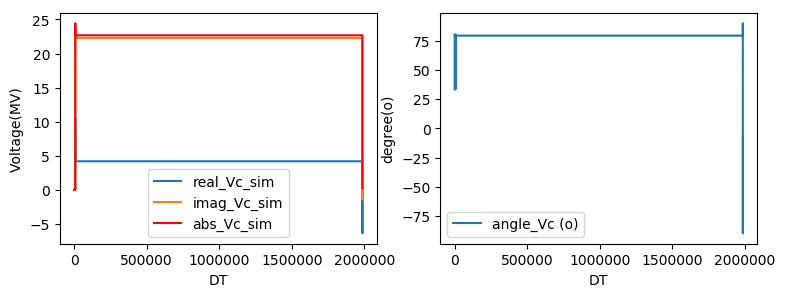

##2 angle_Vc (degree)=79.36434501306285Note: This is exactly equal to sp_phase
##3 kly_add_phase=0.02566890142639311


In [46]:
fig = figure(figsize=(9,3))
#plot(Pbeam)
Ib0*sp_ampl*sin(phisynch)
subplot(121)
plot(real.(Vc_sim)/1e6,label="real_Vc_sim")
plot(imag.(Vc_sim)/1e6,label="imag_Vc_sim")
plot(abs.(Vc_sim)/1e6,"r-",label="abs_Vc_sim")
xlabel("DT")
ylabel("Voltage(MV)")
println("##1 imag_Vc_sim=",imag(Vc_sim[Nbeamon2+200*Nbucket]),", real_Vc_sim=",real(Vc_sim[Nbeamon2+200*Nbucket]),", abs_Vc_sim=",abs(Vc_sim[Nbeamon2+200*Nbucket]))
legend()
#plot(real.(Vc_sim[Nbeamon:Nbeamoff]),imag.(Vc_sim[Nbeamon:Nbeamoff]))
subplot(122)
plot(atan.(imag.(Vc_sim)./real.(Vc_sim))*180/pi,label="angle_Vc (o)")
#ylim(70,81)
println("##2 angle_Vc (degree)=",angle(Vc_sim[Nbeamon2+10*Nbucket])*180/pi,"Note: This is exactly equal to sp_phase")
xlabel("DT")
ylabel("degree(o)")
legend()

kly_add_phase=-(acos(real(Vc_sim[Nbeamon2+200*Nbucket])/sp_ampl)-acos(3.63*1e6/sp_ampl))
println("##3 kly_add_phase=",kly_add_phase)

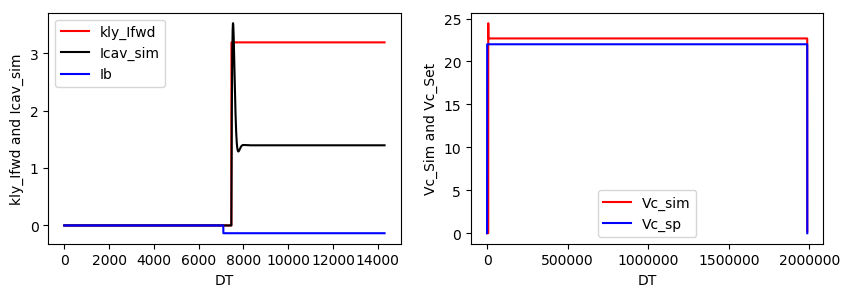

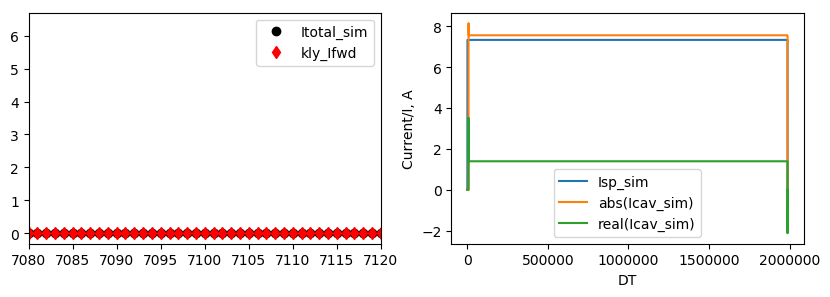

PyObject <matplotlib.legend.Legend object at 0x000000004535B6D8>

In [47]:
ax=1
fig = figure(figsize=(10,3))
#plx_start=Nbeamon;plx_stop=Nbeamon+Nbucket*(Nturn-ax)

subplot(121)
#plx_start=Nbeamoff;plx_stop=Nbeamoff+Nbucket;
plx_start=0*(Nbeamon2+1*Nbucket)+1;plx_stop=(Nbeamon2+20*Nbucket)+1
plot(real(kly_Ifwd[plx_start:plx_stop]),"r-",label=("kly_Ifwd"))
plot(Icav_sim[plx_start:plx_stop],"k-",label=("Icav_sim"))
plot(Ib[plx_start:plx_stop],"b-",label=("Ib"))
#ylim(0,1)
xlabel("DT")
ylabel("kly_Ifwd and Icav_sim")
legend()


subplot(122)
plx_start=0*(Nbeamon2+200*Nbucket)+1;plx_stop=(Nbeamon2+20*Nbucket)*0+Nend
plot(abs.(Vc_sim)[plx_start:plx_stop]/1e6,"r-",label=("Vc_sim"))
plot(sp_volt[plx_start:plx_stop]/1e6,"b-",label="Vc_sp")
xlabel("DT")
ylabel("Vc_Sim and Vc_Set")
legend()

fig = figure(figsize=(10,3))
subplot(121)
plot(Itotal_sim,"ko",label="Itotal_sim")
plot(kly_Ifwd,"rd",label="kly_Ifwd")
xlim(Nbeamon2-20,Nbeamon2+20)
legend()
subplot(122)
plot(Isp_sim,label="Isp_sim")
plot(abs.(Icav_sim),label="abs(Icav_sim)")
plot(real.(Icav_sim),label="real(Icav_sim)")
xlabel("DT")
ylabel("Current/I, A")
legend()

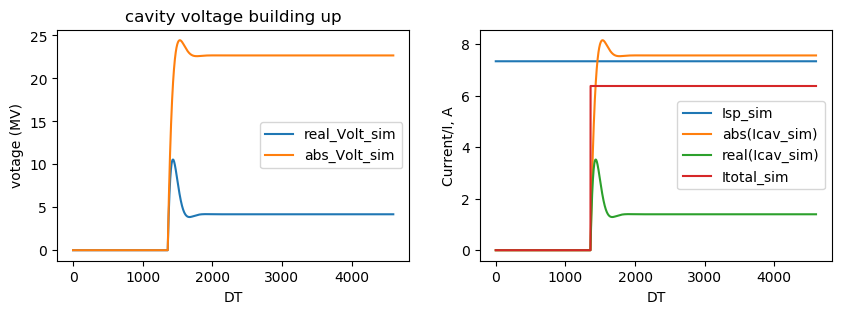

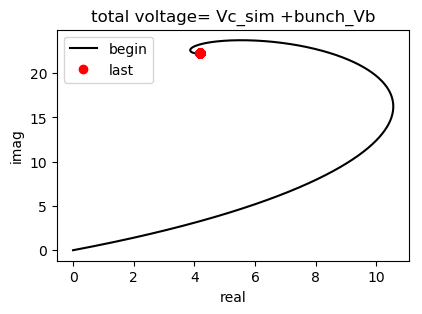

##12, real(Icav) generated voltage:4.185718604868454(MV) abs(Icav) generated voltage (MV):22.679078541542786(MV)


PyObject <matplotlib.legend.Legend object at 0x00000000438C8F60>

In [48]:
fig = figure(figsize=(10,3))
#plx_start=Nbeamon;plx_stop=Nbeamon+Nbucket*(Nturn-ax)

subplot(121)
plx_start=Nbeamon-1000;plx_stop=Nbeamon+Nbucket*10
plot(real.(Icav_sim[plx_start:plx_stop])*RoQ*Qload.*cos.(detuneAngle[plx_start:plx_stop])/2/1e6,label="real_Volt_sim")
plot(abs.(Icav_sim[plx_start:plx_stop])*RoQ*Qload.*cos.(detuneAngle[plx_start:plx_stop])/2/1e6,label="abs_Volt_sim")
title("cavity voltage building up")
xlabel("DT")
ylabel("votage (MV)")
legend()
Vx1=real(Icav_sim[Nbeamon+500Nbucket])*RoQ*Qload*cos(detuneAngle[Nbeamon+500Nbucket])/2/1e6
Vx2=abs(Icav_sim[Nbeamon+500Nbucket])*RoQ*Qload*cos(detuneAngle[Nbeamon+500Nbucket])/2/1e6
println("##12, real(Icav) generated voltage:",Vx1,"(MV) abs(Icav) generated voltage (MV):",Vx2,"(MV)")
subplot(122)
plot(Isp_sim[plx_start:plx_stop],label="Isp_sim")
plot(abs.(Icav_sim[plx_start:plx_stop]),label="abs(Icav_sim)")
plot(real.(Icav_sim[plx_start:plx_stop]),label="real(Icav_sim)")
plot(Itotal_sim[plx_start:plx_stop],label="Itotal_sim")
xlabel("DT")
ylabel("Current/I, A")
legend()
#kly_add_phase=-(acos(Vx1*1e6/sp_ampl)-acos(3.63*1e6/sp_ampl)) # this is the phase that put into the kly_flat_phase

fig = figure(figsize=(10,3))
subplot(121)
plx_start=Nbeamon-1;plx_stop=Nbeamon+Nbucket*300;
plx_delta=plx_stop-plx_start
vtotal=Vc_sim[plx_start:plx_stop]+bunch_Vb[plx_start:plx_stop]*0
plot(real.(vtotal[1:1000])/1e6,imag.(vtotal[1:1000])/1e6,"k-",label="begin")
plot(real.(vtotal[plx_delta-5000:plx_delta])/1e6,imag.(vtotal[plx_delta-5000:plx_delta])/1e6,"ro",label="last")
title("total voltage= Vc_sim +bunch_Vb")
xlabel("real")
ylabel("imag")
legend()

#println("##13 kly_add_phase=",kly_add_phase)

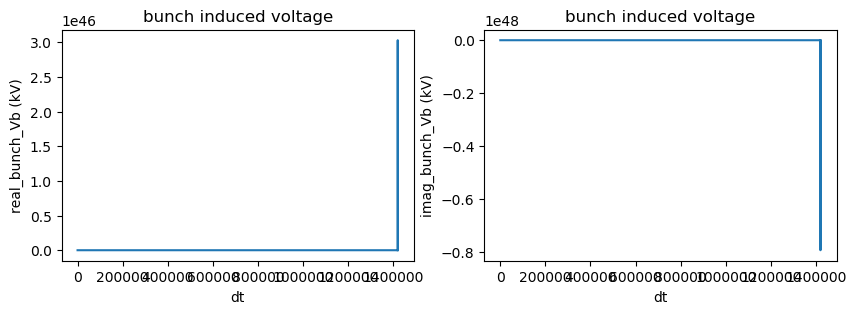

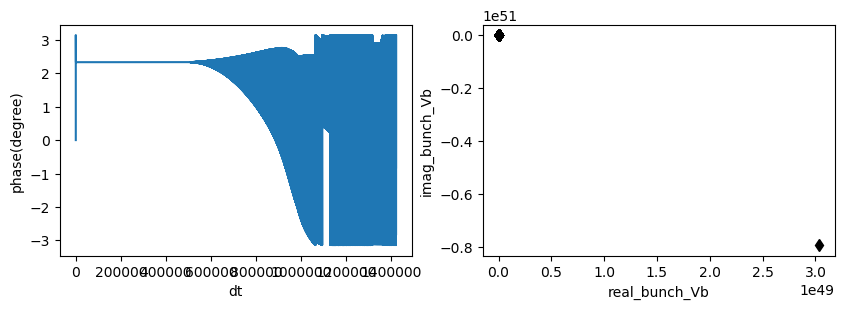

transient beamloading :transient_volt=1.7953519738512114, transient_phase=6.858457827263464e-5

PyObject Text(433.60227272727263, 0.5, 'imag_bunch_Vb')

In [49]:
# calculate the transient beam loading effect
transient_volt1=maximum(real(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))
transient_volt2=minimum(real(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))
transient_phase1=atan(maximum(imag(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]./real(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))))*180/pi
transient_phase2=atan(minimum(imag(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]./real(bunch_Vb[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))))*180/pi
print("transient beamloading :","transient_volt=",transient_volt1-transient_volt2,", transient_phase=",transient_phase1-transient_phase2)


fig = figure(figsize=(10,3))
ax=20
plx_start=Nbeamon+Nbucket*3;plx_stop=Nbeamon+Nbucket*(Nturn-ax);
subplot(121)
plot(real.(bunch_Vb)[plx_start:plx_start+Nbucket*(5000)]./1e3)
xlabel("dt")
ylabel("real_bunch_Vb (kV)")
title("bunch induced voltage")
subplot(122)
plot(imag.(bunch_Vb)[plx_start:plx_start+Nbucket*(5000)]./1e3)
#ylim(-7.0e2,-5e2)
xlabel("dt")
ylabel("imag_bunch_Vb (kV)")
title("bunch induced voltage")

fig = figure(figsize=(10,3))
subplot(121)
plx_start=Nbeamon+Nbucket*0;plx_stop=Nbeamon+Nbucket*5000;
#plot(real(bunch_Vb[plx_start:plx_stop]),imag(bunch_Vb[plx_start:plx_stop]))
#xlabel("real_bunch_Vb")
#ylabel("imag_bunch_Vb")
#title("bunch induced voltage_phase")
#plot(atan.(imag(bunch_Vb[plx_start:plx_stop]./real(bunch_Vb[plx_start:plx_stop])))*180/pi)
plot(angle.(bunch_Vb[plx_start:plx_stop]))
xlabel("dt")
ylabel("phase(degree)")
subplot(122)
plot(real.(bunch_Vb)[Nbeamon+1:Nbeamoff-0],imag.(bunch_Vb)[Nbeamon+1:Nbeamoff-0],"kd")
xlabel("real_bunch_Vb")
ylabel("imag_bunch_Vb")


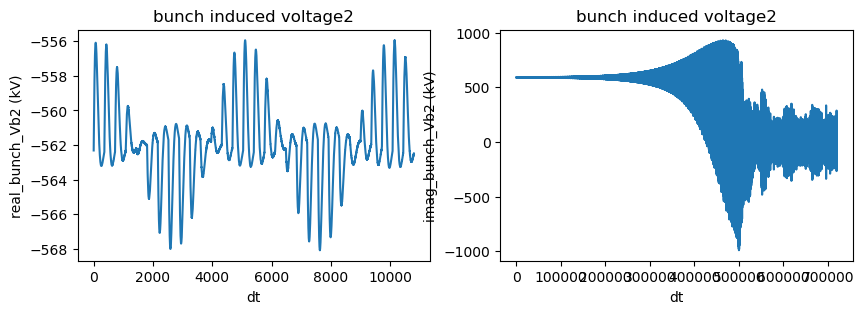

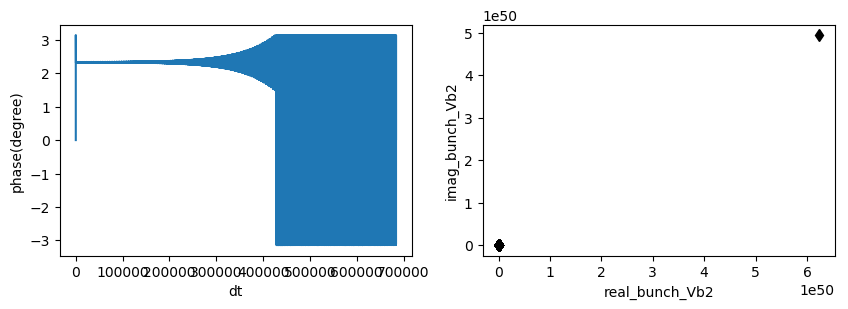

transient beamloading :transient_volt=12366.6819444485, transient_phase=0.8607795683678887

PyObject Text(458.35227272727263, 0.5, 'imag_bunch_Vb2')

In [50]:
# calculate the transient beam loading effect
transient_volt1=maximum(real(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))
transient_volt2=minimum(real(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))
transient_phase1=atan(maximum(imag(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]./real(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))))*180/pi
transient_phase2=atan(minimum(imag(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]./real(bunch_Vb2[Nbeamon+Nbucket*50:Nbeamon+Nbucket*60]))))*180/pi
print("transient beamloading :","transient_volt=",transient_volt1-transient_volt2,", transient_phase=",transient_phase1-transient_phase2)


fig = figure(figsize=(10,3))
ax=20
plx_start=Nbeamon+Nbucket*3;plx_stop=Nbeamon+Nbucket*(Nturn-ax);
subplot(121)
plot(real.(bunch_Vb2)[plx_start:plx_start+Nbucket*(30)]./1e3)
xlabel("dt")
ylabel("real_bunch_Vb2 (kV)")
title("bunch induced voltage2")
subplot(122)
plot(imag.(bunch_Vb2)[plx_start:plx_start+Nbucket*(2000)]./1e3)
#ylim(-7.0e2,-5e2)
xlabel("dt")
ylabel("imag_bunch_Vb2 (kV)")
title("bunch induced voltage2")

fig = figure(figsize=(10,3))
subplot(121)
plx_start=Nbeamon+Nbucket*0;plx_stop=Nbeamon+Nbucket*1900+10;
#plot(real(bunch_Vb[plx_start:plx_stop]),imag(bunch_Vb[plx_start:plx_stop]))
#xlabel("real_bunch_Vb")
#ylabel("imag_bunch_Vb")
#title("bunch induced voltage_phase")
#plot(atan.(imag(bunch_Vb2[plx_start:plx_stop]./real(bunch_Vb2[plx_start:plx_stop])))*180/pi)
plot(angle.(bunch_Vb2[plx_start:plx_stop]))
xlabel("dt")
ylabel("phase(degree)")
subplot(122)
plot(real.(bunch_Vb2)[Nbeamon+1:Nbeamoff-0],imag.(bunch_Vb2)[Nbeamon+1:Nbeamoff-0],"kd")
xlabel("real_bunch_Vb2")
ylabel("imag_bunch_Vb2")

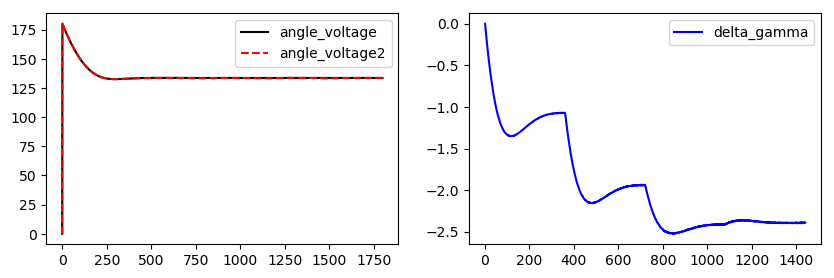

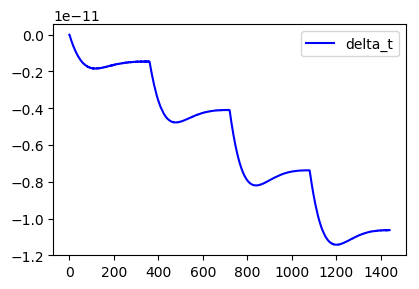

PyObject <matplotlib.legend.Legend object at 0x000000002DBE7630>

In [51]:
xxt=0
fig = figure(figsize=(10,3))
subplot(121)
plx_start=Nbeamon+Nbucket*xxt;plx_stop=Nbeamon+Nbucket*(xxt+5)+0*360;
plot(angle.(bunch_Vb[plx_start:plx_stop])*180/pi,"k-",label="angle_voltage")
plot(angle.(bunch_Vb2[plx_start:plx_stop])*180/pi,"r--",label="angle_voltage2")
legend()
subplot(122)
plot((real.(delta_gamma_all))[plx_start+360:(plx_stop)],"b-",label="delta_gamma")
#plot(abs.(Qb[plx_start:(plx_stop)])/Qb0,"r-",label="Qb")
legend()
fig = figure(figsize=(10,3))
subplot(121)
plot((real.(delta_t2_all))[plx_start+360:(plx_stop)],"b-",label="delta_t")
legend()

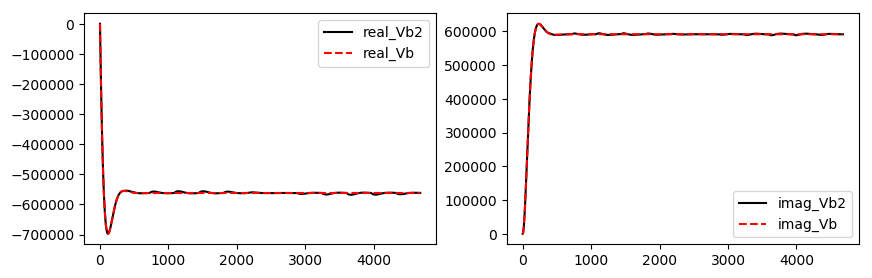

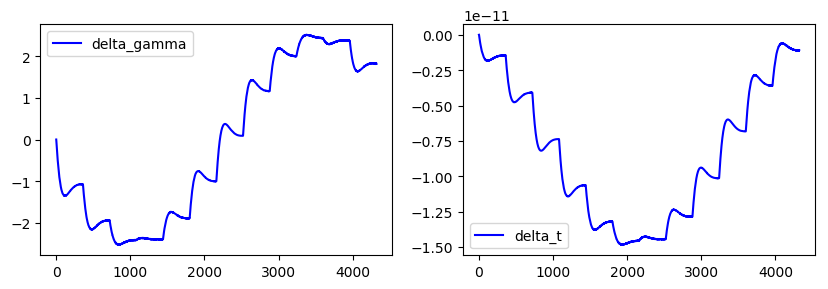

PyObject <matplotlib.legend.Legend object at 0x00000000452DA6D8>

In [52]:
xxt=0
fig = figure(figsize=(10,3))
subplot(121)
plx_start=Nbeamon+Nbucket*xxt;plx_stop=Nbeamon+Nbucket*(xxt+13)+1;
plot(real(bunch_Vb2[plx_start:plx_stop]),"k-",label="real_Vb2")
plot(real(bunch_Vb[plx_start:plx_stop]),"r--",label="real_Vb")
legend()
subplot(122)
plot(imag(bunch_Vb2[plx_start:plx_stop]),"k-",label="imag_Vb2")
plot(imag(bunch_Vb[plx_start:plx_stop]),"r--",label="imag_Vb")
legend()
fig = figure(figsize=(10,3))
subplot(121)
plot((real.(delta_gamma_all))[plx_start+360:(plx_stop)],"b-",label="delta_gamma")
#plot(abs.(Qb[plx_start:(plx_stop)])/Qb0,"r-",label="Qb")
legend()

subplot(122)
plot((real.(delta_t2_all))[plx_start+360:(plx_stop)],"b-",label="delta_t")
legend()

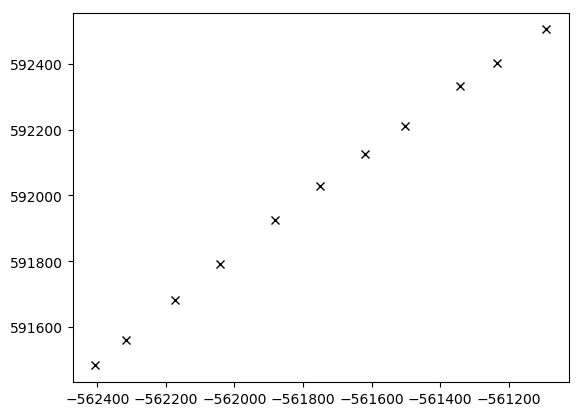

11-element Array{Complex{Float64},1}:
 -562439.6695943868 + 591484.621311182im 
 -562451.0151247281 + 591467.4427967609im
 -562430.5572994234 + 591480.1561380965im
 -562421.6875483271 + 591481.7918615855im
 -562400.6179349164 + 591494.6681498319im
 -562405.7434215136 + 591482.938935893im 
 -562315.4509696781 + 591559.8401423565im
 -562172.8434261755 + 591683.0709288226im
 -562042.3099080245 + 591791.7939849903im
 -561882.5770505844 + 591924.5538343113im
 -561750.1747281273 + 592028.4439244195im

In [53]:
plot(real.(bunch_Vb2)[Nbeamoff-1978200:Nbeamoff-1978190],imag.(bunch_Vb2)[Nbeamoff-1978200:Nbeamoff-1978190],"kx")
#plot(real.(bunch_Vb)[Nbeamon+1:Nbeamoff-0],imag.(bunch_Vb)[Nbeamon+1:Nbeamoff-0],"rd")
bunch_Vb2[Nbeamoff-1978205:Nbeamoff-1978195]

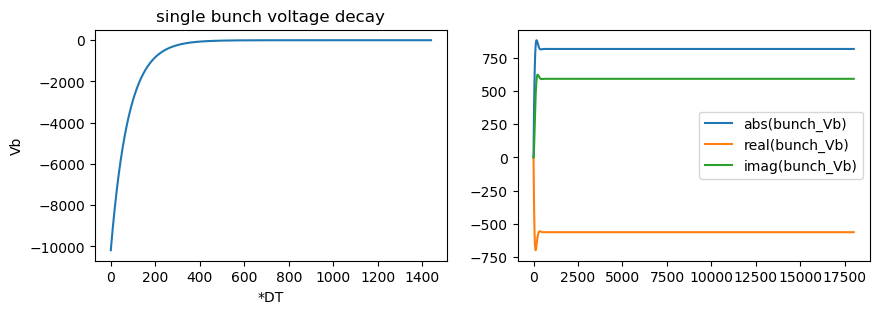

,Tfill_cal=2.8276675249417795e-6 + 0.0im

PyObject <matplotlib.legend.Legend object at 0x00000000451A6710>

In [54]:
plx_start=Nbeamon+1;plx_stop=Nbeamon+Nbucket*3;
#plot(Ib[plx_start:plx_stop]*RoQ*Qload*cos(detuneAngle[Nbeamon+50Nbucket]))
# check the voltage decay
fig = figure(figsize=(10,3))
plx_start=Nbeamon+0;plx_stop=Nbeamon+Nbucket*200;
Vb0_cal=-0.5RoQ*(omegarf-(detuningfreq[Nbeamon+1])*2pi)*Qb[Nbeamon+1]*cos(detuneAngle[Nbeamon+1])
Tfill_cal=2*Qload/(omegarf-(detuningfreq[Nbeamon+1]))
t_cal=range(0,length=4*Nbucket,stop=4*Nbucket)
vb_cal(t)=Vb0_cal*exp(-t*DT/Tfill_cal)
subplot(121)
plot(map(t->real(vb_cal(t)),t_cal))
xlabel("*DT")
ylabel("Vb")
title("single bunch voltage decay")
print(",Tfill_cal=",Tfill_cal)
subplot(122)
plot(abs.(bunch_Vb[Nbeamon:Nbeamon+50*Nbucket])/1000,label="abs(bunch_Vb)")
plot(real.(bunch_Vb[Nbeamon:Nbeamon+50*Nbucket])/1000,label="real(bunch_Vb)")
plot(imag.(bunch_Vb[Nbeamon:Nbeamon+50*Nbucket])/1000,label="imag(bunch_Vb)")
legend()
#plot(10000*Ib[Nbeamon:Nbeamon+50*Nbucket])

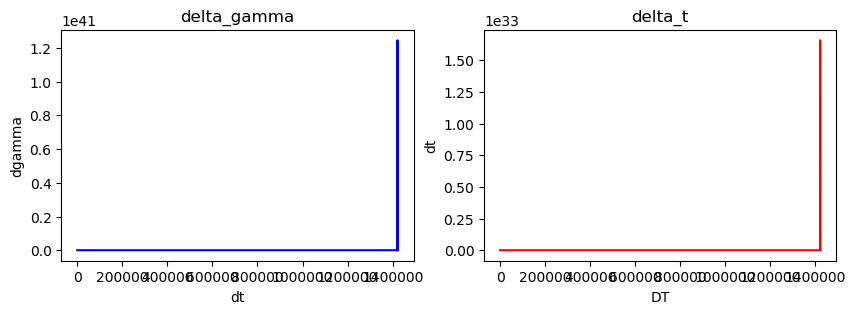

detuningfreq=60000, Qb=3.0e10 + 0.0im,detuneAngle=46.83244797948569

In [55]:
# plot phase space
fig = figure(figsize=(10,3))
plx_start=Nbeamon2+1;plx_stop=Nbeamon2+Nbucket*(Nturn-BD_delay-10);
subplot(121)
plot((real.(delta_gamma_all))[plx_start:(plx_stop)]/gamma0,"b-")
xlabel("dt")
ylabel("dgamma")
title("delta_gamma")
subplot(122)
plot(delta_t2_all[plx_start:(plx_stop)],"r-")
xlabel("DT")
ylabel("dt")
title("delta_t")


#subplot(122)
#plot((real.(delta_gamma_all))[plx_start:(plx_stop)],(imag.(delta_gamma_all))[plx_start:(plx_stop)],"bd")
#ylim(-7.0e5,-5e5)
#xlabel("real_gamma")
#ylabel("imag_gamma")
#title("gamma")
print("detuningfreq=",deltaf,", Qb=",Qbfactor*Qb[Nbeamon+Nbucket*Nturn_delay+1]/qe,",detuneAngle=",180/pi*detuneAngle[1])


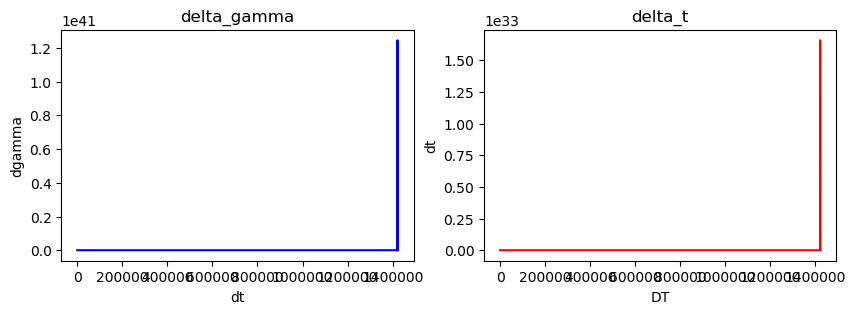

detuningfreq=60000, Qb=3.0e10 + 0.0im,detuneAngle=46.83244797948569

In [56]:
# plot phase space
fig = figure(figsize=(10,3))
plx_start=Nbeamon2+1;plx_stop=Nbeamon2+Nbucket*(Nturn-BD_delay-10);
subplot(121)
plot((real.(delta_gamma_all))[plx_start:(plx_stop)]/gamma0,"b-")
xlabel("dt")
ylabel("dgamma")
title("delta_gamma")
subplot(122)
plot(delta_t2_all[plx_start:(plx_stop)],"r-")
xlabel("DT")
ylabel("dt")
title("delta_t")


#subplot(122)
#plot((real.(delta_gamma_all))[plx_start:(plx_stop)],(imag.(delta_gamma_all))[plx_start:(plx_stop)],"bd")
#ylim(-7.0e5,-5e5)
#xlabel("real_gamma")
#ylabel("imag_gamma")
#title("gamma")
print("detuningfreq=",deltaf,", Qb=",Qbfactor*Qb[Nbeamon+Nbucket*Nturn_delay+1]/qe,",detuneAngle=",180/pi*detuneAngle[1])


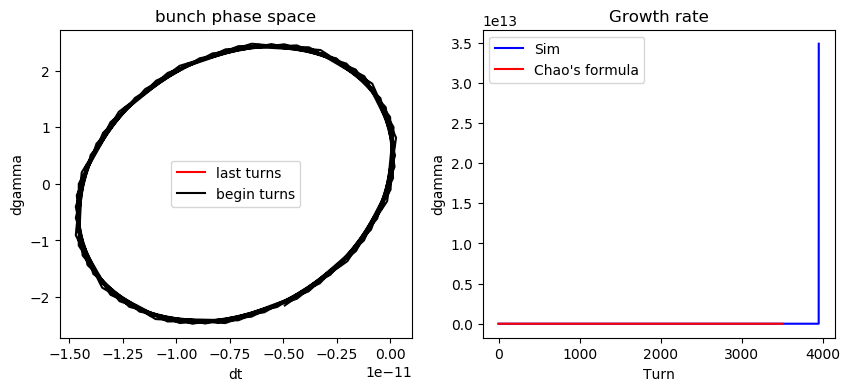

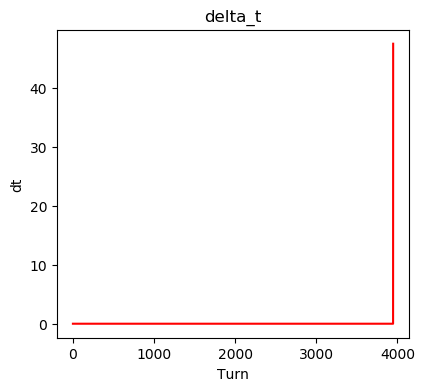

OneOtau1_chao=405.8335934223213,OneOtau2_chao=-90.10602705786363,OneOtau3_chao=-102.75500474028775

PyObject Text(0.5, 1.0, 'delta_t')

In [57]:
function get_bunchgt(nth)
    delta_gamma_bunch=zeros(Complex{Float64},Nturn-BD_delay)
    delta_t2_bunch=zeros(Complex{Float64},Nturn-BD_delay)
    for i= 1:Nturn-5-BD_delay
        delta_gamma_bunch[i]=delta_gamma_all[Nbeamon2+Nbucket*i+nth]
        delta_t2_bunch[i]=delta_t2_all[Nbeamon2+Nbucket*i+nth]
    end
    return delta_gamma_bunch,delta_t2_bunch
end
figure(figsize=(10,4))
subplot(121)

plx_start=(Nturn-500-BD_delay);plx_stop=(Nturn-10-BD_delay)
delta_gamma_bunch,delta_t2_bunch=get_bunchgt(1);
plot(delta_t2_bunch[plx_start:plx_stop],delta_gamma_bunch[plx_start:plx_stop],"r-",label=("last turns"))

plx_start=1;plx_stop=100
delta_gamma_bunch,delta_t2_bunch=get_bunchgt(1);
plot(delta_t2_bunch[plx_start:plx_stop],delta_gamma_bunch[plx_start:plx_stop],"k-",label=("begin turns"))
legend()
xlabel("dt")
ylabel("dgamma")
title("bunch phase space")


subplot(122)
plx_start=1;plx_stop=(Nturn-200)
plot(delta_gamma_bunch[plx_start:plx_stop],"b-",label=("Sim"))
xlabel("Turn")
ylabel("dgamma")
title("Growth rate")



#plot robinson
OneOtau2_chao=Qbfactor*(Nbunch*Qb0/qe*re0*eta*2pi*frf/(2*gamma0*trev*trev*2pi*fsyn)*real(Zcavity(frf+fsyn,deltaf)-Zcavity(frf-fsyn,deltaf)))
OneOtau1_chao=Qbfactor*real(Nbunch*Qb0/qe*re0*eta/(2*gamma0*trev*trev*2pi*fsyn)*2pi*(frf+fsyn)*Zcavity(frf+fsyn,deltaf))
OneOtau3_chao=Qbfactor*(Nbunch*Qb0/qe*re0*eta*RoQ*Qload*Qload*Qload*-deltaf*2pi/(pi*gamma0*trev*frf/frev))  # note the deltaf define opposite in Chao's bool
print( "OneOtau1_chao=",OneOtau1_chao,",OneOtau2_chao=",OneOtau2_chao,",OneOtau3_chao=",OneOtau3_chao)

t=range(0,length=3500,stop=3500)
phi_growth(t)=maximum(real.(delta_gamma_bunch[1:200]))*exp(-t*trev*(1)*abs(OneOtau3_chao)*1)*cos(2pi*fsyn*t*trev*0)
robinson=map(t->phi_growth(t),t)


plot(t,robinson,"r-",label=("Chao's formula"))
real(delta_gamma_all[Nbeamon+1])
delta_gamma_bunch[1]
legend()
#xlim(0,100)

figure(figsize=(10,4))
subplot(122)
plx_start=1;plx_stop=(Nturn-200)
plot(delta_t2_bunch[plx_start:plx_stop],"r-",label=("delta_t"))
xlabel("Turn")
ylabel("dt")
title("delta_t")


In [58]:
Ib0

0.1352548747381366

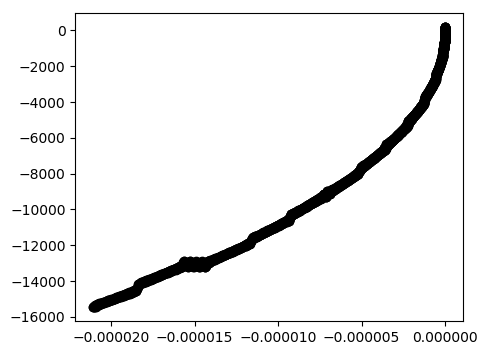

1.87e-10

In [59]:
#Separatrix pass
figure(figsize=(5,4))
Hex=omega_rev*sp_ampl/(2pi*ebeta*gamma0*0.511e6)*(-2cos(phisynch)+(pi-2*phisynch)*sin(phisynch));
dgama1(phix)=sqrt(abs(Hex-omega_rev*sp_ampl/(2pi*ebeta*gamma0*0.511e6)*(cos(phix)-cos(phisynch)+(phix-phisynch)*sin(phisynch))))
dgama2(phix)=-sqrt(abs(Hex-omega_rev*sp_ampl/(2pi*ebeta*gamma0*0.511e6)*(cos(phix)-cos(phisynch)+(phix-phisynch)*sin(phisynch))))
phix1=range(-0pi,length=5000,stop=2pi)
plot((phix1.-phisynch)/(2pi*omegarf),map(x->dgama1(x),phix1),"r",(phix1.-phisynch)/(2pi*omegarf),map(x->dgama2(x),phix1))
plx_start=1;plx_stop=3400
plot(delta_t2_bunch[plx_start:plx_stop],delta_gamma_bunch[plx_start:plx_stop],"ko",label=("last turns"))
tauhat


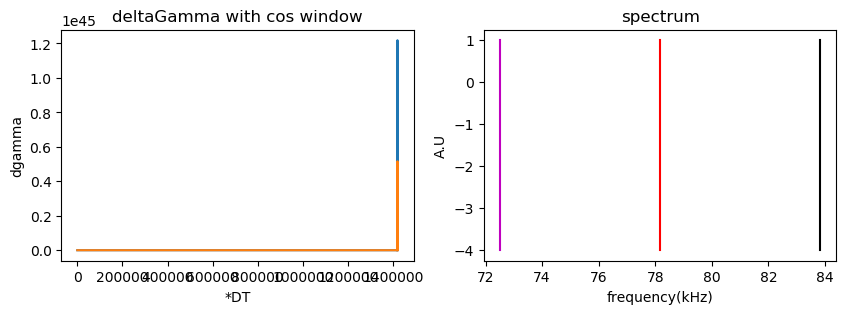

PyObject Text(448.22727272727263, 0.5, 'A.U')

In [60]:


# FFT the bunch
figure(figsize=(10,3))
plx_start=Nbeamon+5*Nbucket;plx_stop=Nbeamon+Nbucket*(Nturn-30);
data=delta_gamma_all[plx_start:(plx_stop)]
Nsampling=length(data)
ST=Nsampling*DT
x = (0.0:DT:(Nsampling-1)*DT)
subplot(121)
plot(data)
xlabel("dT")
ylabel("dgamma")
title("delta_gamma for FFT")

#Define cosine function
Coswindow=zeros(Nsampling)
Coswindow=map(x->cos(x/ST*pi/2),x)
ycoswindow=data.*Coswindow
plot(ycoswindow)
title("deltaGamma with cos window")
xlabel("*DT")
ylabel("dgamma")

n=length(data)
p=fft(ycoswindow)
nUniquePts = ceil(Int, (n+1)/2)
sampFreq=1/DT
p = p[1:nUniquePts]
p = abs.(p)
p = p / n #scale
# odd nfft excludes Nyquist point
if n % 2 > 0
    p[2:length(p)] = p[2:length(p)]*2 # we've got odd number of   points fft
else
    p[2: (length(p) -1)] = p[2: (length(p) -1)]*2 # we've got even number of points fft
end

subplot(122)
stx=10;spx=ceil(Int,n/2.02)
freqArray = (stx:(nUniquePts-spx)) * (sampFreq  / n)
plot(freqArray/1e3,(log10.(real(p))[stx:(nUniquePts-spx)]))


#plot a line
linepoint=20
xline1=frev/1e3*ones(linepoint);xline2=(frev-fsyn)/1e3*ones(linepoint);xline3=(frev+fsyn)/1e3*ones(linepoint)
yline1=range(-4, length=linepoint, stop=1)
plot(xline1,yline1,"r-",xline2,yline1,"m-",xline3,yline1,"k-")
title("spectrum")
xlabel("frequency(kHz)")
ylabel("A.U")




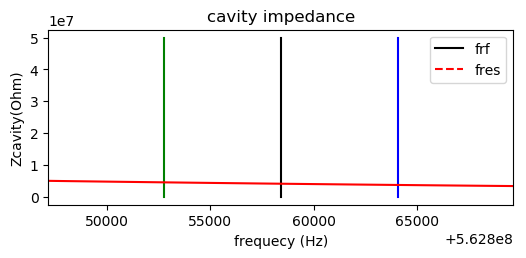

OneOtau1_chao=-4.383921776533404e-11,OneOtau2_chao=-8.3431522536333e-12

In [61]:
## Robinson check

fig = figure(figsize=(6,5))

function Zcavity(f,df)
    Qext=1/(1/Qload-1/Q0)
    fcavity=frf-df
    Z=Qext*RoQ/(1+(Qext*(f/fcavity-fcavity/f))*1im)
    return Z
end


f=range(frf-frf*0.02, length=10000, stop=frf+frf*0.02);
Zimp=map(f->Zcavity(f,deltaf),f);
subplot(211)
linepoint=20
xline1=frf*ones(linepoint);xline2=(frf-fsyn)*ones(linepoint);xline3=(frf+fsyn)*ones(linepoint);
xline4=(frf-deltaf)*ones(linepoint)
yline1=range(0e7, length=linepoint, stop=5e7)
plot(xline1,yline1,"k-",label="frf")
plot(xline2,yline1,"g-",xline3,yline1,"b-")
plot(f,real(Zimp),"r-")
plot(xline4,yline1,"r--",label="fres")
xlim(frf-frf*0.00002,frf+frf*0.00002)
legend()
title("cavity impedance")
xlabel("frequecy (Hz)")
ylabel("Zcavity(Ohm)")

#growth_Tau=1/(2*Ib0*1*2*pi*fsyn*real(Zcavity(frf+fsyn,deltaf)-Zcavity(frf-fsyn,deltaf))/2/(sp_ampl*cos(sp_phase*pi/180)))
OneOtau2_chao=(Ne*re0*eta*2pi*frf/(2*gamma0*trev*trev*2pi*fsyn)*real(Zcavity(frf+fsyn,deltaf)-Zcavity(frf-fsyn,deltaf)))
OneOtau1_chao=imag(Ne*re0*eta/(2*gamma0*trev*trev*2pi*fsyn)*2*pi*(frf+fsyn)*Zcavity(frf+fsyn,deltaf))
print( "OneOtau1_chao=",OneOtau1_chao,",OneOtau2_chao=",OneOtau2_chao)

t=range(0,length=1000,stop=50)
phi_growth(t)=exp(-t*trev/OneOtau1_chao)*cos(2pi*fsyn*t*trev*0)
robinson=map(t->phi_growth(t),t);

#subplot(212)
#plot(t,robinson)
#xlabel("turn")
#ylabel("amplitude")



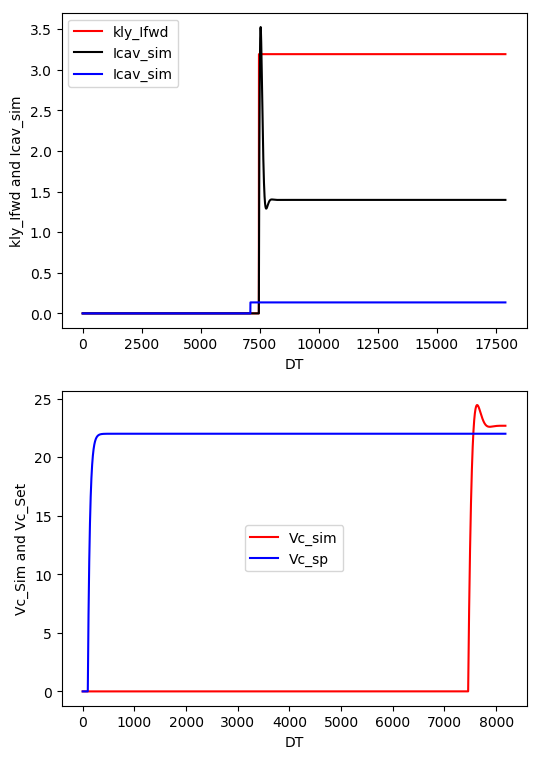

243041.13217555766 - 33190.12304626556im break point243041.13217555766 - 33190.12304626556im

PyObject <matplotlib.legend.Legend object at 0x000000002DBF2780>

In [62]:
ax=1
fig = figure(figsize=(6,9))
#plx_start=Nbeamon;plx_stop=Nbeamon+Nbucket*(Nturn-ax)

subplot(211)
#plx_start=Nbeamoff;plx_stop=Nbeamoff+Nbucket;
plx_start=0*(Nbeamon+200*Nbucket)+1;plx_stop=(Nbeamon+30*Nbucket)+1
plot(real(kly_Ifwd[plx_start:plx_stop]),"r-",label=("kly_Ifwd"))
plot(Icav_sim[plx_start:plx_stop],"k-",label=("Icav_sim"))
plot(-Ib[plx_start:plx_stop],"b-",label=("Icav_sim"))
#ylim(0,1)
xlabel("DT")
ylabel("kly_Ifwd and Icav_sim")
legend()

print(Vc_sim[Nend]," break point",Vc_sim[Nend])
size(Ib)
subplot(212)
plx_start=0*(Nbeamon+200*Nbucket)+1;plx_stop=(Nbeamon+3*Nbucket)+1
plot(abs.(Vc_sim)[plx_start:plx_stop]/1e6,"r-",label=("Vc_sim"))
plot(abs.(sp_volt)[plx_start:plx_stop]/1e6,"b-",label="Vc_sp")
xlabel("DT")
ylabel("Vc_Sim and Vc_Set")
legend()

In [63]:
#growth_Tau=1/(2*Ib0*1*2*pi*fsyn*real(Zcavity(frf+fsyn,deltaf)-Zcavity(frf-fsyn,deltaf))/2/(sp_ampl*cos(sp_phase*pi/180)))
OneOtau2_chao=(Ne*re*eta*2pi*frf/(2*gamma0*trev*trev*2pi*fsyn)*real(Zcavity(frf+fsyn,deltaf)-Zcavity(frf-fsyn,deltaf)))
OneOtau1_chao=imag(Ne*re*eta/(2*gamma0*trev*trev*2pi*fsyn)*2*pi*(frf+fsyn)*Zcavity(frf+fsyn,deltaf))
print( "OneOtau1_chao=",OneOtau1_chao,",OneOtau2_chao=",OneOtau2_chao)

UndefVarError: UndefVarError: re not defined

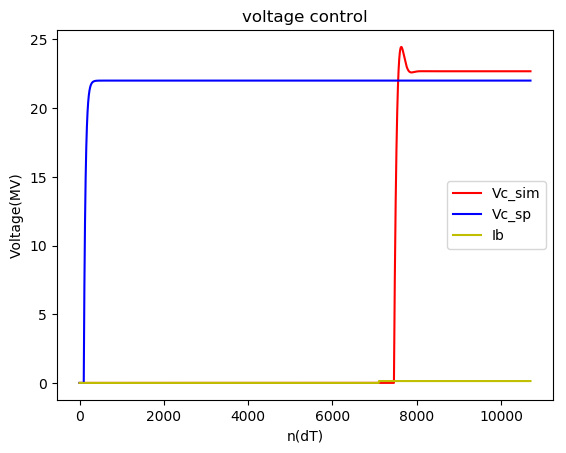

PyObject Text(0.5, 24.0, 'n(dT)')

In [64]:
plx_start=Nbeamon*0+1;plx_stop=Nbeamon+10*Nbucket;
plot(abs.(Vc_sim)[plx_start:plx_stop]/1e6,"r-",label=("Vc_sim"))    
plot(abs.(sp_volt)[plx_start:plx_stop]/1e6,"b-",label="Vc_sp")
#ylim(sp_ampl/1e6*(1-0.15),sp_ampl/1e6*(1+0.05))
legend()
plot(-1*Ib[plx_start:plx_stop],"y",label=("Ib"))
legend()
title("voltage control")
ylabel("Voltage(MV)")
xlabel("n(dT)")

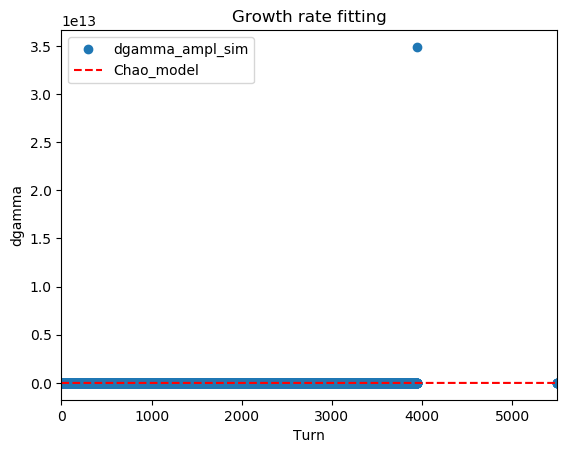

Chao_model=8.3431522536333e-12fitted=8.3431522536333e-12

PyObject Text(0.5, 1.0, 'Growth rate fitting')

In [65]:
# moving window and find the max
delta_gamma_bunch_ampl=zeros(length(delta_gamma_bunch))
for i=2:length(delta_gamma_bunch)
    binsize=60
       delta_gamma_bunch_ampl[i]=real.(delta_gamma_bunch[i])
   
end
plot(delta_gamma_bunch_ampl,label=("dgamma_ampl_sim"),"o")
xlabel("*turn")
ylabel("dgamma")

legend()


@. model(x, p) = real(delta_gamma_bunch_ampl[1])*exp(-x*trev*p[1])

# xdata: independent variables
# ydata: dependent variable
xdata =range(1,length=length(delta_gamma_bunch_ampl),stop=length(delta_gamma_bunch_ampl))
ydata = delta_gamma_bunch_ampl
p0 = [OneOtau2_chao]

fitx2 = curve_fit(model, xdata, ydata, p0)

#errorsx2 = estimate_errors(fitx2, 0.95)
#fig=figure(figsize=(4,3))

#plot(xdata,ydata)
#covarx2=estimate_covar(fitx2)

plot(xdata,map(x->delta_gamma_bunch_ampl[1]*exp(-fitx2.param[1]*trev*x),xdata),"r--",label=("Chao_model"))
xlim(1,length(delta_gamma_bunch_ampl))
print("Chao_model=",abs(OneOtau2_chao),"fitted=",abs(fitx2.param[1]))

legend()
xlabel("Turn")
ylabel("dgamma")
title("Growth rate fitting")

In [66]:
Vb01=0.5*RoQ*fres*2pi*Qb0  # bunch induced total voltage   
Vb02=Qb0*wakemode(fres*2pi,RoQ,Qload,0)  #wak
print("single partilce=",Vb01,"Wakemodel=",Vb02)


single partilce=14887.459704497302Wakemodel=14887.459704497302

In [67]:
qx(phix)=sp_ampl*cos(pi-phisynch)/(2*pi*fres*RoQ/2)/(sin(phix)*cos(phix))/qe

qx (generic function with 1 method)

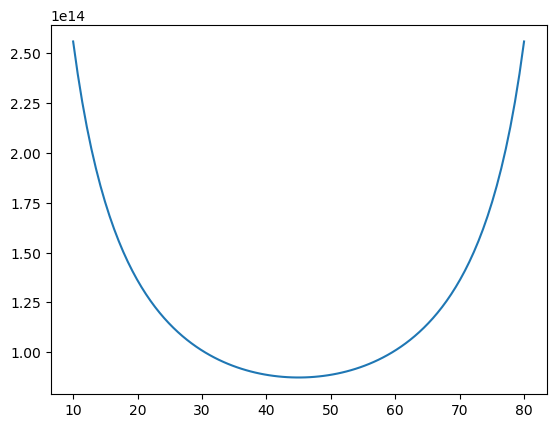

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000044F69DD8>

In [68]:
phix=range(10,length=100,stop=(80));
plot(phix,map(x->qx(x),phix*pi/180))

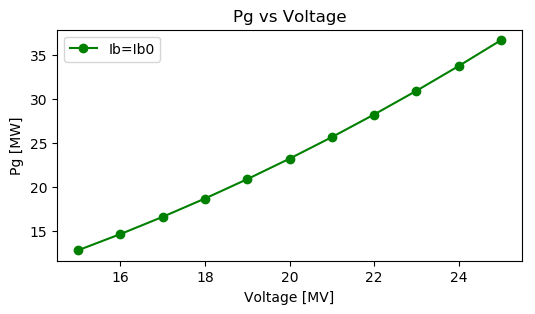

4.599999e6

In [69]:
# Plot Power data


function PgkW(Vc,beta,Ib)
    deltaW=2pi*(real(detuningfreq).+(2*rand(1)[1]-1)*mech_uphonics)
    tanPsi=-2*Qload*deltaW./(frf.-real(detuningfreq))/2/pi
    detuneAngle=atan.(tanPsi)
    a1=Vc^2/(RoQ*Q0)*(1+beta)^2/4/beta
    a2=(1+abs(Ib)*RoQ*Q0*cos(pi/180*sp_phase)/Vc/(1+beta))^2
    a3=(tan(detuneAngle[1])+abs(Ib)*RoQ*Q0*sin(pi/180*sp_phase)/Vc/(1+beta))^2
    return a1*(a2+a3)
end


vcx = 15:1:25.2

fig=figure(figsize=(6,3))

plot(vcx,map(vcx->real(PgkW(vcx*1e6,beta,Ib0)/1e6),vcx),"go-",label="Ib=Ib0")
# Legend the plot
title("Pg vs Voltage")
xlabel("Voltage [MV]")
ylabel("Pg [MW]")
legend(loc="upper left")
beta

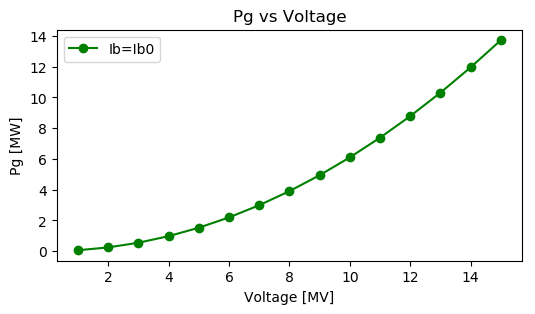

7.648732727811586e6

In [70]:
fig=figure(figsize=(6,3))
vcx = 1:1:15
plot(vcx,map(vcx->real(PgkW(vcx*1e6,beta,0)/1e6),vcx),"go-",label="Ib=Ib0")
# Legend the plot
title("Pg vs Voltage")
xlabel("Voltage [MV]")
ylabel("Pg [MW]")
legend(loc="upper left")
PgkW(11.2*1e6,beta,0)

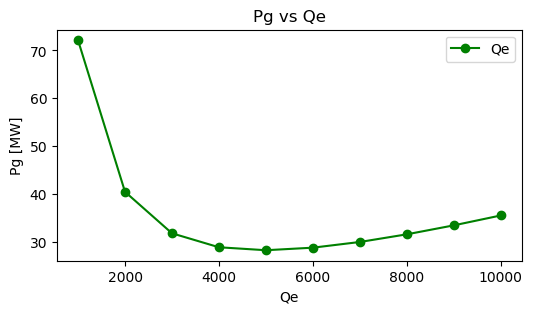

PyObject <matplotlib.legend.Legend object at 0x000000004850FDA0>

In [71]:
function PgkW(Vc,beta,Ib,deltaf)
    Qe=Q0/beta
    Qload=1/(1/Q0+1/Qe)
    tanPsi=-2*Qload*deltaf/(frf-deltaf)
    detuneAngle=atan.(tanPsi)
    a1=Vc^2/(RoQ*Q0)*(1+beta)^2/4/beta
    a2=(1+abs(Ib)*RoQ*Q0*cos(pi/180*sp_phase)/Vc/(1+beta))^2
    a3=(tan(detuneAngle[1])+abs(Ib)*RoQ*Q0*sin(pi/180*sp_phase)/Vc/(1+beta))^2
    return a1*(a2+a3)
end

fig=figure(figsize=(6,3))
Qex=range(1e3,length=10,stop=1e4)
#betaX=Q0./Qex
#plot(betaX,map(beta->real(PgkW(22*1e6,beta,Ib0)/1e6),betaX),"go-",label="Ib=Ib0")
plot(Qex,map(Qex->real(PgkW(22*1e6,Q0/Qex,Ib0,deltaf)/1e6),Qex),"go-",label="Qe")
# Legend the plot
# Legend the plot
title("Pg vs Qe")
xlabel("Qe")
ylabel("Pg [MW]")
legend(loc="upper right")


In [72]:
deltaf

60000